In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
WSL + Kali Linux,315.765837,63.153167,100.500997,5
VMWare,546.426581,12.707595,33.570897,43
Audit Report Tracker (Sharepoint List),757.490270,84.165586,189.206201,9
C# Basics,869.227741,28.039605,75.007722,31
Azure Private DNS,948.394250,49.915487,123.176151,19
Logging in Python,975.182516,69.655894,219.732823,14
Azure AD Authentication,1097.180226,84.398479,250.351670,13
Azure Compute Gallery,1134.595817,28.364895,97.823169,40
Azure Functions + Visual Studio,1136.775093,87.444238,188.832439,13
Email Auth and Security,1168.729738,97.394145,254.196468,12


# Histogram

sum of ages: ~48530.43


<Axes: >

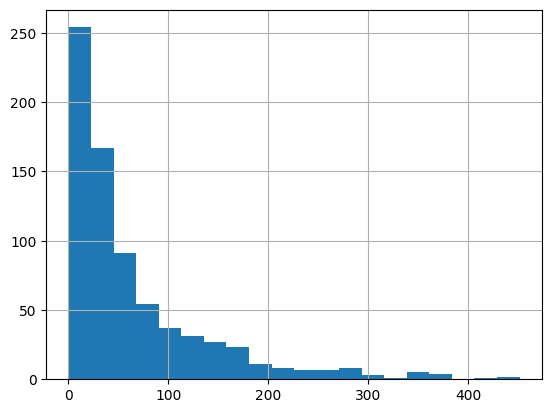

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 741
Total card age: 48530.43


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
151,WSL + Kali Linux,Xorg\nThe open-source implementation of the X ...,a9445cafce144bd9f3ea44bda5d2fece,-100.500997,63.153167,-100.500997,315.765837,0.897192,5,100.500997
182,WSL + Kali Linux,X11 (X Window System)\nA graphical windowing s...,7f12a8a48e2528038d5ff93886dfcd09,-85.518693,63.153167,-100.500997,315.765837,0.897192,5,100.500997
214,WSL + Kali Linux,Xfwm4 (XFCE Window Manager)\nThe window manage...,594e6944d7db563ed70cf869889eebb7,-75.515616,63.153167,-100.500997,315.765837,0.897192,5,100.500997
325,WSL + Kali Linux,D-Bus\nA message bus system that allows applic...,92ba71c8e472d2a79c0d687e0d02acc9,-45.034685,63.153167,-100.500997,315.765837,0.897192,5,100.500997
637,WSL + Kali Linux,WSL Networking\nAccessing Windows Network Serv...,d95dda7c5befaeea7cac809212d5c205,-9.195847,63.153167,-100.500997,315.765837,0.897192,5,100.500997
53,Audit Report Tracker (Sharepoint List),Create Column in List (for creating new column...,389cbfe707ad368888f40926ff5f7ac7,-189.206201,84.165586,-189.206201,757.490270,0.507103,9,189.206201
56,Audit Report Tracker (Sharepoint List),Column (SharePoint Column)\nDefinition: A fiel...,3320c1d28b4a2badbaf91d674cdaec02,-188.690570,84.165586,-189.206201,757.490270,0.507103,9,189.206201
188,Audit Report Tracker (Sharepoint List),List Items Endpoint (for retrieving items in a...,ab53dedb8adaa3ad12a6afcdb2e1dd65,-83.426003,84.165586,-189.206201,757.490270,0.507103,9,189.206201
198,Audit Report Tracker (Sharepoint List),Graph Explorer\nDefinition: A tool provided by...,ce03a3830816aa7288446e54b9961462,-80.395251,84.165586,-189.206201,757.490270,0.507103,9,189.206201
225,Audit Report Tracker (Sharepoint List),Content Type (SharePoint)\nDefinition: A reusa...,550cbe9de496b31e34c1526cce280209,-68.635046,84.165586,-189.206201,757.490270,0.507103,9,189.206201


# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [14]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [20]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
0,JavaScript Concepts,Hot Module Replacement (HMR): A feature in bun...,62eed610b799097eb68b6e656481e34c,-451.316827,120.217341,-451.316827,6251.301743,0.757267,52,451.316827
1,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-440.335433,82.159737,-440.335433,1725.354479,0.342632,21,440.335433
2,JavaScript Concepts,Spread and Rest Operators (...): Operators tha...,c6d7508de1e7714c70e2314c3435af41,-409.386657,120.217341,-451.316827,6251.301743,0.757267,52,451.316827
3,JavaScript Concepts,Switch Statement\nswitch (expression) {\n c...,640dd8e068d96778d3079d9a38f3175a,-381.325143,120.217341,-451.316827,6251.301743,0.757267,52,451.316827
5,JavaScript Concepts,Async/Await: Syntax for handling asynchronous ...,1cec5db45adcdd9803ca27cafafec52c,-372.019246,120.217341,-451.316827,6251.301743,0.757267,52,451.316827
4,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-370.747880,70.981102,-370.747880,4258.866103,0.943783,60,370.747880
6,Python,Q:\nWhat happens if you try to call gen.next()...,a56125c87641d3bb052be7366138b43a,-370.414190,93.816350,-370.414190,3471.204967,0.906043,37,370.414190
7,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-361.013319,82.159737,-440.335433,1725.354479,0.342632,21,440.335433
8,Debugging in VS Code,"1. Debugger\nA tool used to inspect, control, ...",e5f2354be4982ffd49ff5162d37e9a30,-358.987892,89.592037,-358.987892,1523.064631,0.570664,17,358.987892
9,JavaScript Concepts,Dependency Injection: A design pattern used in...,6ce1630383ba0769e21a6141a2968ff6,-349.175504,120.217341,-451.316827,6251.301743,0.757267,52,451.316827


In [18]:
existing_cards.head(10).sum()

head                   WSL + Kali LinuxWSL + Kali LinuxWSL + Kali Lin...
body                   Xorg\nThe open-source implementation of the X ...
hash                   a9445cafce144bd9f3ea44bda5d2fece7f12a8a48e2528...
age                                                          -926.118908
subject_mean_age                                              736.593765
subject_highest_age                                         -1448.535987
subject_age_sum                                              5366.280535
head_random_roll                                                7.021476
frequency                                                             70
oldest                                                       1448.535987
dtype: object

In [19]:
existing_cards['age'].mean()

-65.49316144458146